<a href="https://colab.research.google.com/github/evischotman/TM10007-Machine-Learning_group10/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template

In [ ]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git
!pip install statsmodels

  Preparing metadata (setup.py) ... done


# Constants:


In [ ]:
# constants
test_size = 0.2     # test-train split 20-80
random_state = 1
n_features = 100    # ranking top features for feature selection
n_plots = 5         # number of features to plot after ANOVA
num_folds = 15      # number of folds in cross-validation (fold = 10st by 15, 20st by 7)
top_knn = 20        # Selection of top_features for KNN training (ANOVA based)

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [ ]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
#from worclipo.load_data import load_data
from worcliver.load_data import load_data
#from ecg.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 186
The number of columns: 494


# Evaluation of the data



In [ ]:
label_counts = data['label'].value_counts()
print(label_counts)

label
malignant    94
benign       92
Name: count, dtype: int64


# Split test/train

Data is split in a train and test dataset. The testset remains untouched untill training of the model is completed. Further data inspection and preprocessing is performed on the traindata only.

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming 'data' contains your entire dataset where the first column is ID, the second column is labels,
# and the remaining columns are features

# Split the data into features (X) and labels (y)
X = data.iloc[:, 1:]  # Features (assuming features start from the 3rd column)
y = data.iloc[:, 0]   # Labels (assuming labels are in the second column)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

#transform label pd.serie to binary pd.serie (0=benign, 1=malign)
y_mapping = {"benign": 0, "malignant": 1}
y_train = pd.Series({key: y_mapping[value] for key, value in y_train.items()}, name='ID')
y_test = pd.Series({key: y_mapping[value] for key, value in y_test.items()}, name='ID')

# Print the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (148, 493)
Shape of X_test: (38, 493)
Shape of y_train: (148,)
Shape of y_test: (38,)


# Check for duplicates, missing data and check for constant values


In [ ]:
import pandas as pd

# Check for duplicates
duplicates = X_train[X_train.duplicated()]
if not duplicates.empty:
    print(f"Duplicates found:{duplicates}\n")
else:
    print("No duplicates found\n")

if not duplicates.empty:
    X_train.drop_duplicates(inplace=True)
    print("Duplicates removed\n.")

# check for missing data
missing_values = X_train.columns[X_train.isna().any()].tolist()
if missing_values:
    print(f"colums with missing data: {missing_values}\n")
else:
    print("No missing data found\n")

# Check voor constant
constant_columns = X_train.columns[X_train.apply(pd.Series.nunique) == 1].tolist()
print(f"Aantal features with constant values = {len(constant_columns)}")
print(constant_columns)

# Remove features from datalist
X_train.drop(columns=constant_columns, inplace=True)
print(f'New amount of features: {len(X_train.columns)-1}')

No duplicates found

No missing data found

Aantal features with constant values = 19
['PREDICT_original_tf_LBP_min_R3_P12', 'PREDICT_original_tf_LBP_max_R3_P12', 'PREDICT_original_tf_LBP_peak_R3_P12', 'PREDICT_original_tf_LBP_peak_position_R3_P12', 'PREDICT_original_tf_LBP_range_R3_P12', 'PREDICT_original_tf_LBP_max_R8_P24', 'PREDICT_original_tf_LBP_peak_R8_P24', 'PREDICT_original_tf_LBP_peak_position_R8_P24', 'PREDICT_original_tf_LBP_max_R15_P36', 'PREDICT_original_tf_LBP_peak_R15_P36', 'PREDICT_original_tf_LBP_peak_position_R15_P36', 'PREDICT_original_vf_Frangi_full_peak_position_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_edge_peak_position_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_phasef_phasecong_min_WL3_N5', 'PREDICT_original_phasef_phasecong_peak_WL3_N5', 'PREDICT_original_phasef_phasecong_peak_position_WL3_N5', 'PREDICT_original_phasef_phasesym_min_WL3_N5', 'PREDICT_original_phasef_phasesym_peak_WL3_N5', 'PREDICT_original_phasef_phasesym_peak_position_WL3_N5']
New amount o

# Analysing data and testing for the best scaling method

Testing for gaussian distribution with Shapio-Wilk test

In [ ]:
from scipy.stats import shapiro

# Empty list to store Shapiro-Wilk test p-values
p_values = []

# Iterate over each feature column
for column in X_train:
    # Perform Shapiro-Wilk test
    stat, p_value = shapiro(X_train[column])
    p_values.append(p_value)

# Calculate average p-value
average_p_value = sum(p_values) / len(p_values)

print(f"Average p-value for Shapiro-Wilk test across all features: {average_p_value:.4f}")

Average p-value for Shapiro-Wilk test across all features: 0.0311


Calculaire normality scores

In [ ]:
#Calculate normality scores for each feature
normality_scores = [1 - p for p in p_values]

# Calculate average normality score
average_normality_score = sum(normality_scores) / len(normality_scores)

print(f"Average normality score across all features: {average_normality_score:.4f}")

Average normality score across all features: 0.9689


Calculation outliers

In [ ]:
# Empty list to store outlier scores for each feature
outlier_scores = []

# Iterate over each feature column
for colmn in X_train:
    # Calculate the interquartile range (IQR)
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count the number of outliers
    num_outliers = ((X_train[column] < lower_bound) | (X_train[column] > upper_bound)).sum()

    # Calculate outlier score (percentage of outliers)
    outlier_score = num_outliers / len(X_train) * 100

    # Store outlier score for the feature
    outlier_scores.append((column, outlier_score))

# Calculate average outlier score
average_outlier_score = sum(score for _, score in outlier_scores) / len(outlier_scores)

print(f"Average outlier score across all features: {average_outlier_score:.2f}%")

Average outlier score across all features: 0.68%


# Data scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import pandas as pd

# Initialize the Scaler
#scaler = MinMaxScaler ()
#scaler = StandardScaler()
scaler = RobustScaler()

X_train_copy = X_train
X_train = scaler.fit_transform(X_train)

# Convert created list back to a dataframe:
X_train = pd.DataFrame(X_train, columns=X_train_copy.columns)
print(X_train)

     PREDICT_original_sf_compactness_avg_2.5D  \
0                                    0.121074   
1                                    0.179842   
2                                   -0.274557   
3                                    0.126296   
4                                    0.834697   
..                                        ...   
143                                 -0.286464   
144                                  0.287271   
145                                  0.377805   
146                                 -0.604285   
147                                 -2.914073   

     PREDICT_original_sf_compactness_std_2.5D  \
0                                   -0.340191   
1                                   -0.406029   
2                                   -0.022367   
3                                   -0.151154   
4                                   -0.154667   
..                                        ...   
143                                  0.780370   
144                

# Feature selection- testing:

In this section, different methods for feature selection are tested. This is needed becase the data containrs more features than samples. The following methods are tested: Pearson, Spearman, ANOVA and Kendall. All methods are used in testing and remain accesable. Considering the shape and type of data, ANOVA is choosen as method for selection and therefore printed only

ANOVA (non-lineair)

In [ ]:
from sklearn.feature_selection import f_classif
from statsmodels.sandbox.stats.multicomp import multipletests

# ANOVA on trainset
f_values, p_values = f_classif(X_train, y_train)

# bonferroni correction
_, p_corrected, _, _ = multipletests(p_values, method='bonferroni')

#ranking'
feature_p_values = list(zip(X_train.columns, p_corrected))
feature_p_values.sort(key=lambda x: x[1])

top_features_ANOVA = feature_p_values[:n_features]

#plot ranking with correlated p-value
for feature, p_value in top_features_ANOVA:
    print(f"Kenmerk: {feature}, p-waarde: {p_value:.2f}")


Kenmerk: PREDICT_original_tf_Gabor_min_F0.05_A2.36, p-waarde: 0.04
Kenmerk: PREDICT_original_hf_quartile_range, p-waarde: 0.05
Kenmerk: PREDICT_original_logf_quartile_range_sigma1, p-waarde: 0.07
Kenmerk: PREDICT_original_hf_std, p-waarde: 0.09
Kenmerk: PREDICT_original_logf_kurtosis_sigma1, p-waarde: 0.15
Kenmerk: PREDICT_original_hf_range, p-waarde: 0.17
Kenmerk: PREDICT_original_sf_area_max_2.5D, p-waarde: 0.17
Kenmerk: PREDICT_original_tf_LBP_std_R3_P12, p-waarde: 0.23
Kenmerk: PREDICT_original_tf_LBP_quartile_range_R8_P24, p-waarde: 0.25
Kenmerk: PREDICT_original_tf_LBP_skewness_R8_P24, p-waarde: 0.26
Kenmerk: PREDICT_original_tf_Gabor_min_F0.05_A0.79, p-waarde: 0.27
Kenmerk: PREDICT_original_tf_LBP_kurtosis_R8_P24, p-waarde: 0.33
Kenmerk: PREDICT_original_tf_Gabor_quartile_range_F0.5_A2.36, p-waarde: 0.36
Kenmerk: PREDICT_original_tf_Gabor_std_F0.05_A2.36, p-waarde: 0.50
Kenmerk: PREDICT_original_tf_Gabor_range_F0.05_A2.36, p-waarde: 0.52
Kenmerk: PREDICT_original_tf_Gabor_skewne

Kendall's tau-b

In [ ]:
from scipy.stats import kendalltau
from statsmodels.sandbox.stats.multicomp import multipletests

kendall_corr = []

for feature in X_train.columns:
    corr, _ = kendalltau(X_train[feature], y_train)
    kendall_corr.append((feature, corr))

kendall_corr.sort(key=lambda x: abs(x[1]), reverse=True)

#p-values and bonferroni
p_values = [abs(corr) for _, corr in kendall_corr]
_, p_corrected, _, _ = multipletests(p_values, method='bonferroni')
top_features_Kendall = [(feature, corr) for (feature, _), corr in zip(kendall_corr, p_corrected)]
top_features_Kendall.sort(key=lambda x: x[1])

top_features_Kendall = top_features_Kendall[:n_features]

# Plot ranking with correlation coëfficient
#for feature, corr in top_features_Kendall:
 #   print(f"Kenmerk: {feature}, Kendall's tau-b correlatiecoëfficiënt: {corr}")

# Plotting different feature selection results:

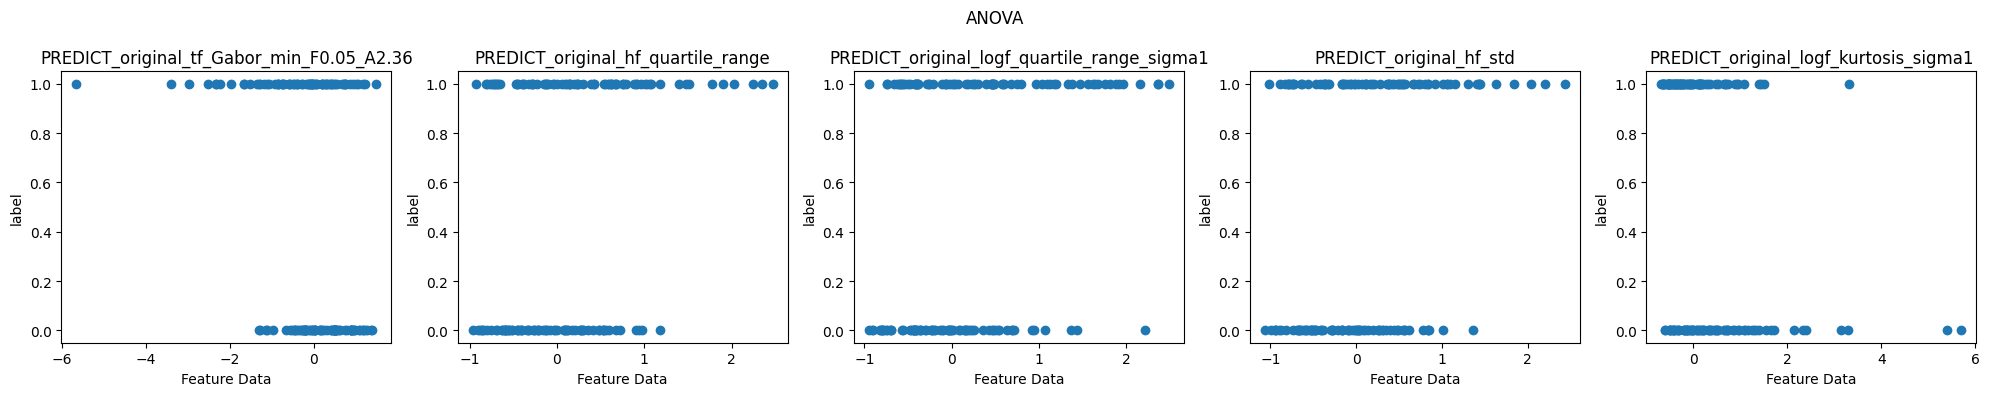

In [ ]:
import matplotlib.pyplot as plt

# ANOVA
top_features_ANOVA_plot = [feature for feature, _ in top_features_ANOVA[:n_plots]]
fig, axes = plt.subplots(nrows=1, ncols=n_plots, figsize=(20, 4))
for i, feature in enumerate(top_features_ANOVA_plot):
    ax = axes[i]
    ax.scatter(X_train[feature], y_train)
    ax.set_title(feature)
    ax.set_xlabel('Feature Data')
    ax.set_ylabel('label')
fig.suptitle("ANOVA")
plt.tight_layout()
plt.show()

# Kendall's tau-b
# top_features_Kendall_plot = [feature for feature, _ in top_features_Kendall[:n_plots]]
# fig, axes = plt.subplots(nrows=1, ncols=n_plots, figsize=(20, 4))
# for i, feature in enumerate(top_features_Kendall_plot):
#     ax = axes[i]
#     ax.scatter(X_train[feature], y_train)
#     ax.set_title(feature)
#     ax.set_xlabel('Feature Data')
#     ax.set_ylabel('label')
# fig.suptitle("Kendall's tau-b")
# plt.tight_layout()
# plt.show()

# t-SNE plot

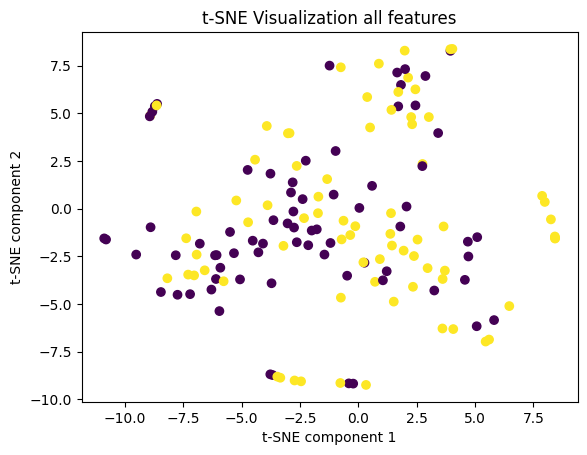

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Initialize t-SNE with desired parameters
tsne = TSNE(n_components=2)

# Perform t-SNE
X_embedded = tsne.fit_transform(X_train)

# Plot results
plt.figure()
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap='viridis')
plt.title('t-SNE Visualization all features')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

# Scatterplots and classifiers try-out

In this section, scatterplots are made of the best three distinctive features according to the feature selection. This scatterplots acquire insight of the distribution of the labeled data. On this small problems, different classifiers are tried to test performance. This helps and support the discion for the right classifier.

In [ ]:
n_scatterplot = 3
top_features_scatterplot = [feature for feature, _ in top_features_ANOVA[:n_scatterplot]]
X_train_scatterplot = X_train[top_features_scatterplot]

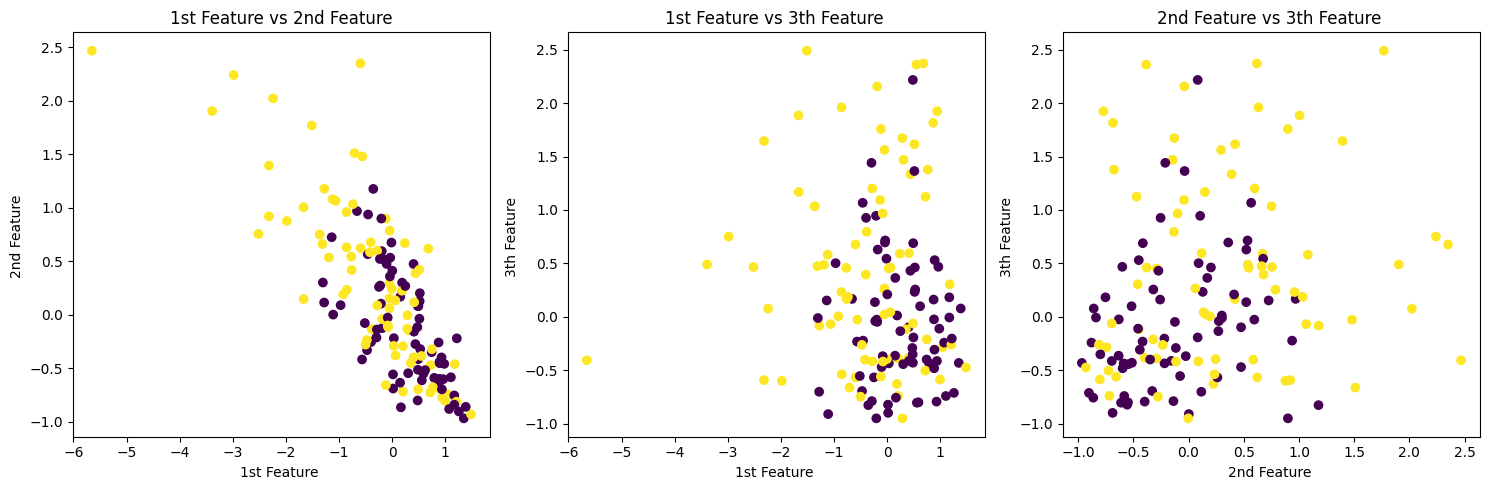

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(X_train_scatterplot.iloc[:, 0], X_train_scatterplot.iloc[:, 1], c=y_train)
axs[0].set_xlabel('1st Feature ')
axs[0].set_ylabel('2nd Feature ')
axs[0].set_title('1st Feature vs 2nd Feature')

axs[1].scatter(X_train_scatterplot.iloc[:, 0], X_train_scatterplot.iloc[:, 2], c=y_train)
axs[1].set_xlabel('1st Feature ')
axs[1].set_ylabel('3th Feature ')
axs[1].set_title('1st Feature vs 3th Feature ')

axs[2].scatter(X_train_scatterplot.iloc[:, 1], X_train_scatterplot.iloc[:, 2], c=y_train)
axs[2].set_xlabel('2nd Feature ')
axs[2].set_ylabel('3th Feature ')
axs[2].set_title('2nd Feature vs 3th Feature ')

plt.tight_layout()
plt.show()

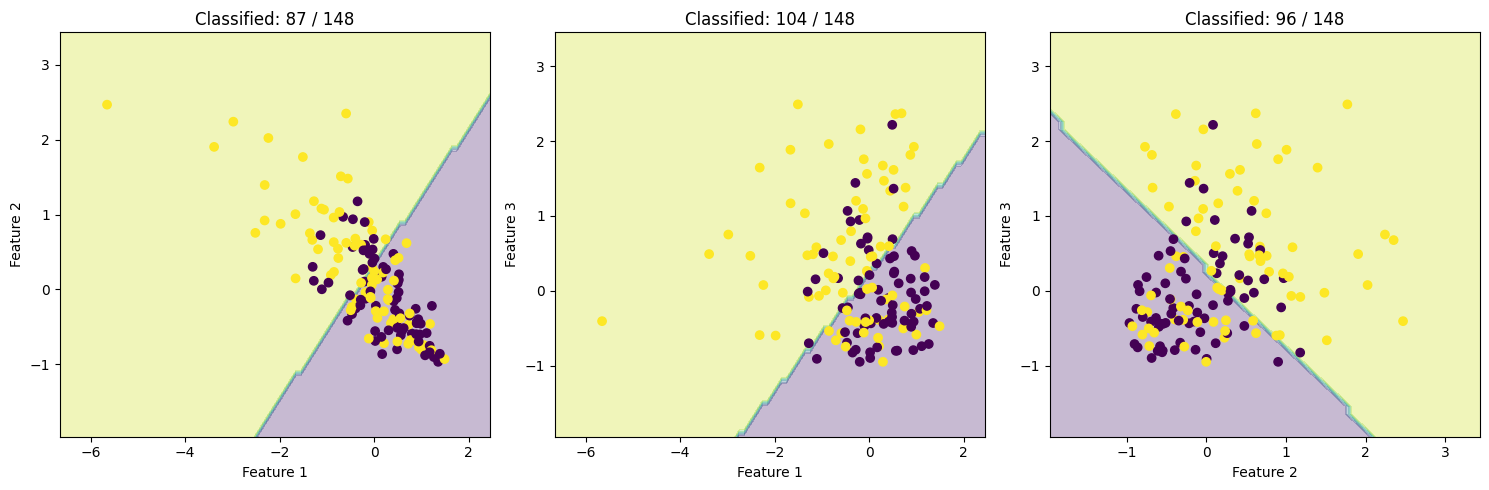

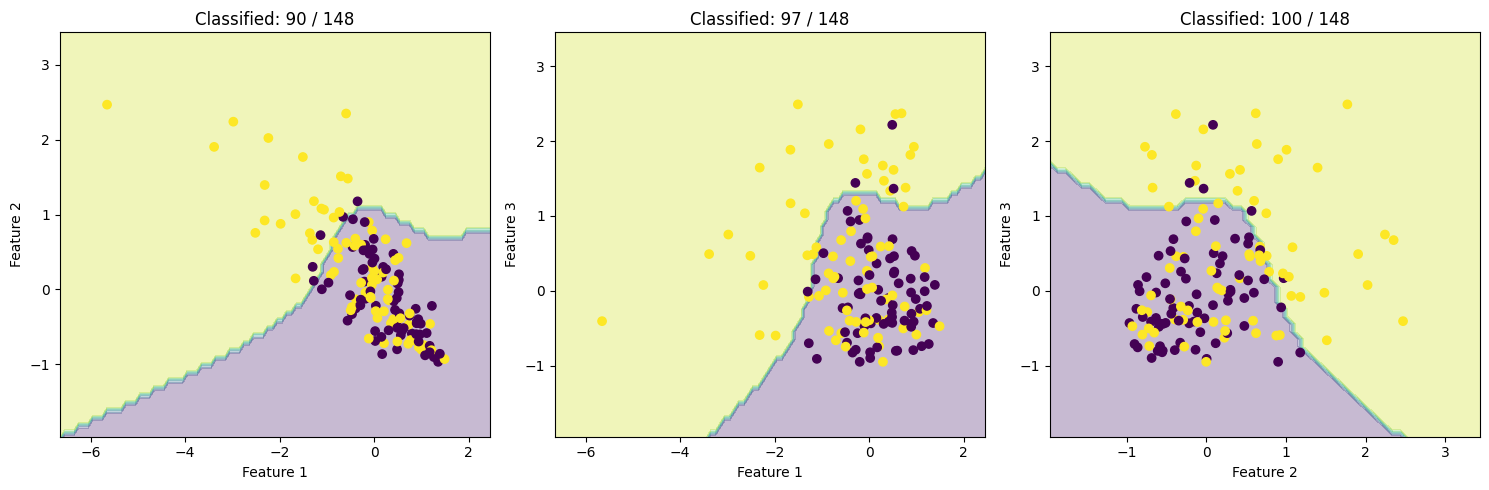

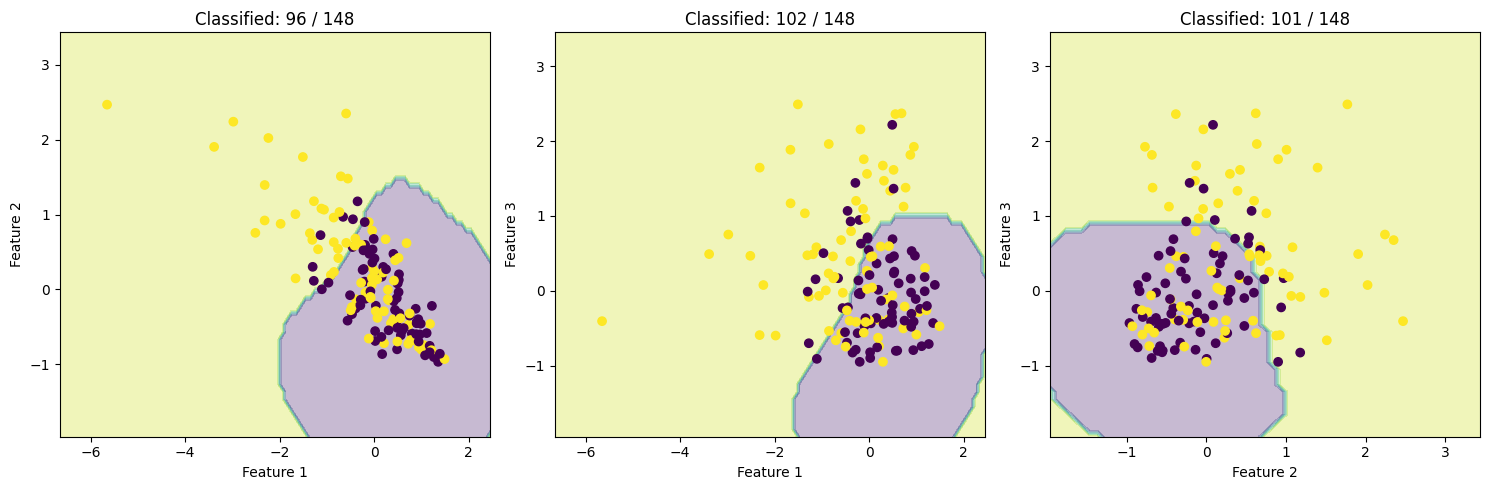

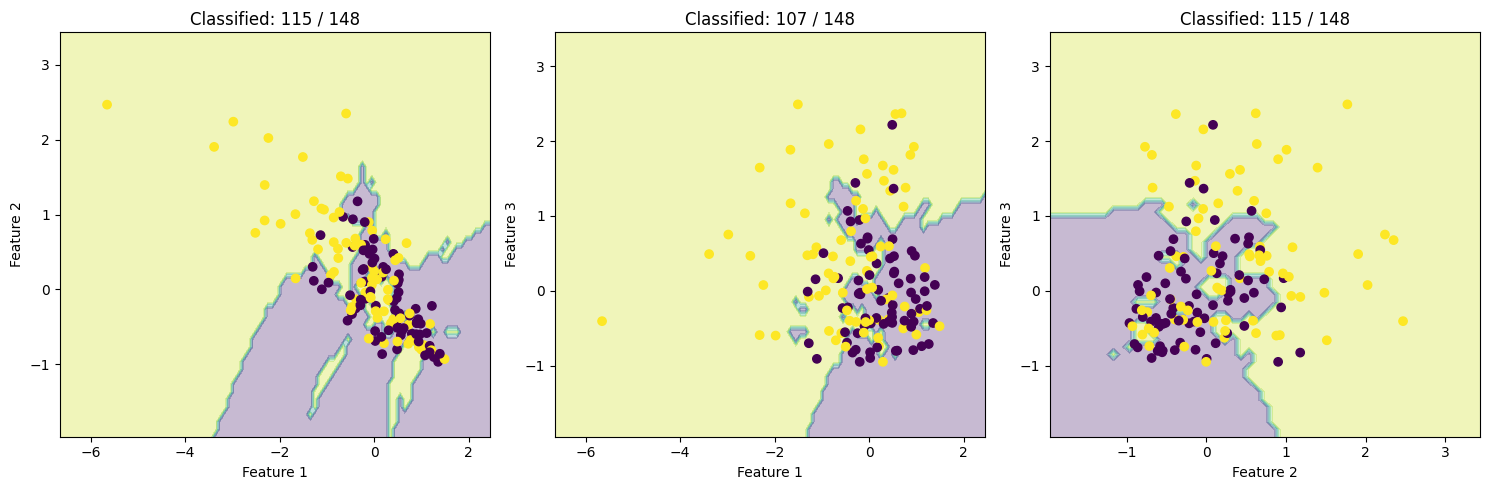

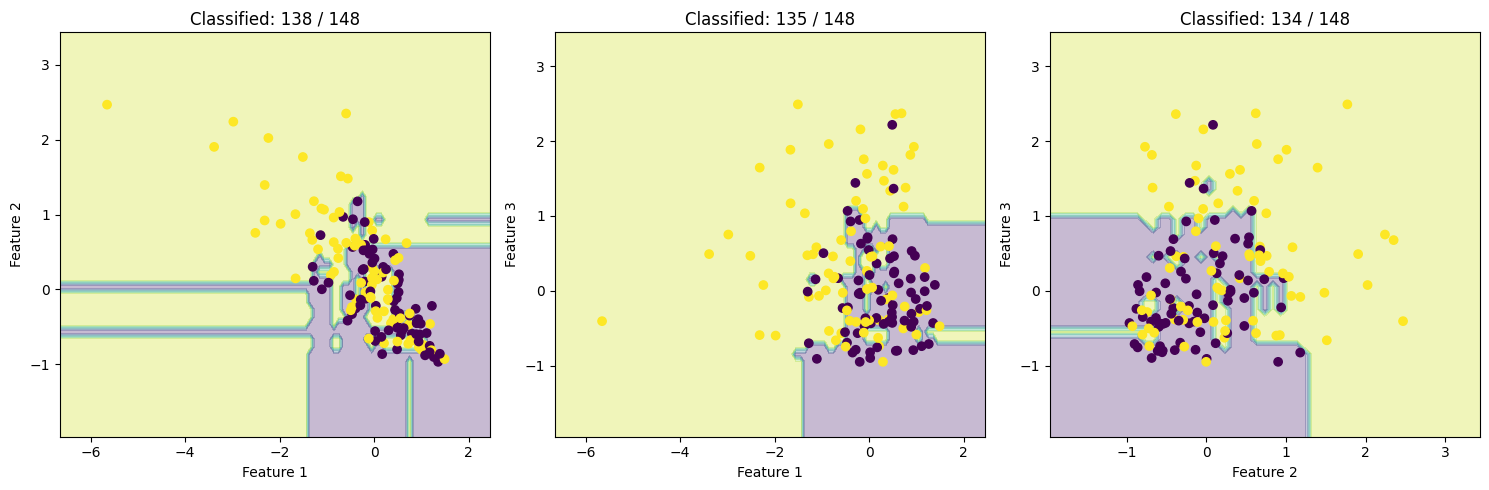

Average Accuracy for SVC: 0.67
Average Accuracy for KNeighborsClassifier: 0.76
Average Accuracy for RandomForestClassifier: 0.92


In [ ]:
# hide redundant warnings that occur in this section
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
import numpy as np

##############################################################################################################

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from itertools import combinations

# define classifiers and their hyperparameters
knn_try = KNeighborsClassifier(n_neighbors=5, weights='uniform')
rfc_try = RandomForestClassifier(n_estimators=100,
                                 max_depth=10,
                                 min_samples_split=5,
                                 min_samples_leaf=2,
                                 max_features='sqrt')
classifiers = [
    SVC(kernel='linear', gamma='scale'),
    SVC(kernel='poly', degree=3, gamma='scale'),
    SVC(kernel='rbf', gamma='scale'),
    knn_try,
    rfc_try,
]

# Dictionary to store accuracy
accuracy_scores = {}

# Loop the classifiers over scatterplots
for clf in classifiers:
    accuracies = []

    # Subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs = axs.flatten()

    for ax, (feat1, feat2) in zip(axs, combinations(range(X_train_scatterplot.shape[1]), 2)):
        # Training classifiers
        clf.fit(X_train_scatterplot.iloc[:, [feat1, feat2]], y_train)

        # predictions
        y_pred = clf.predict(X_train_scatterplot.iloc[:, [feat1, feat2]])

        accuracy = accuracy_score(y_train, y_pred)
        accuracies.append(accuracy)

        # Meshgrid with decision boundaries
        xx, yy = np.meshgrid(np.arange(X_train_scatterplot.iloc[:, feat1].min() - 1, X_train_scatterplot.iloc[:, feat1].max() + 1, 0.1),
                             np.arange(X_train_scatterplot.iloc[:, feat2].min() - 1, X_train_scatterplot.iloc[:, feat2].max() + 1, 0.1))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        # Plot descison boundaries
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')

        # Scatterplot main scatterplots
        ax.scatter(X_train_scatterplot.iloc[:, feat1], X_train_scatterplot.iloc[:, feat2], c=y_train)
        ax.set_xlabel('Feature ' + str(feat1 + 1))
        ax.set_ylabel('Feature ' + str(feat2 + 1))

        # calculate misclassiefieds
        misclassified = (y_train != y_pred).sum()

        # Set the title
        ax.set_title(f'Classified: {len(y_train) - misclassified} / {len(y_train)}')

    # Calculatie average accuarcy for SVC
    avg_accuracy = np.mean(accuracies)
    accuracy_scores[type(clf).__name__] = avg_accuracy

    plt.tight_layout()
    plt.show()

# Print accuracy
for clf_name, accuracy in accuracy_scores.items():
    print(f"Average Accuracy for {clf_name}: {accuracy:.2f}")

# Feature selection:

It appears that all methods select more or less the same distinctive features. To methodize our selection for features, we assume the data for both categorical and numerical input/output. Therefore, choosing the ANOVA-statistics test. For modelling, we select a relative large amount of best features. With this set, we perform a Recursive feature elimination with cross validation to select the optimal number of features. Finally, a new dataset is made from the train dataset with only the desired features.

In [ ]:
import pandas as pd

#preselected_features = [(feature) for feature, p_value in feature_p_values if p_value < 0.05]
#preselected_features = [feature for feature, _ in top_features_pearson[:n_features]]
#preselected_features = [feature for feature, _ in top_features_spearman[:n_features]]
preselected_features = [feature for feature, _ in top_features_ANOVA[:n_features]]
#preselected_features = [feature for feature, _ in top_features_Kendall[:n_features]]

X_train_preselected = X_train[preselected_features]

print("top features:", preselected_features)
print("Shape of training set:", X_train_preselected.shape)

top features: ['PREDICT_original_tf_Gabor_min_F0.05_A2.36', 'PREDICT_original_hf_quartile_range', 'PREDICT_original_logf_quartile_range_sigma1', 'PREDICT_original_hf_std', 'PREDICT_original_logf_kurtosis_sigma1', 'PREDICT_original_hf_range', 'PREDICT_original_sf_area_max_2.5D', 'PREDICT_original_tf_LBP_std_R3_P12', 'PREDICT_original_tf_LBP_quartile_range_R8_P24', 'PREDICT_original_tf_LBP_skewness_R8_P24', 'PREDICT_original_tf_Gabor_min_F0.05_A0.79', 'PREDICT_original_tf_LBP_kurtosis_R8_P24', 'PREDICT_original_tf_Gabor_quartile_range_F0.5_A2.36', 'PREDICT_original_tf_Gabor_std_F0.05_A2.36', 'PREDICT_original_tf_Gabor_range_F0.05_A2.36', 'PREDICT_original_tf_Gabor_skewness_F0.5_A0.0', 'PREDICT_original_tf_LBP_mean_R8_P24', 'PREDICT_original_tf_Gabor_quartile_range_F0.05_A2.36', 'PREDICT_original_sf_area_std_2.5D', 'PREDICT_original_tf_Gabor_min_F0.2_A2.36', 'PREDICT_original_tf_Gabor_quartile_range_F0.5_A0.0', 'PREDICT_original_tf_Gabor_quartile_range_F0.5_A0.79', 'PREDICT_original_tf_Ga

# Recursive feature elimination with cross validation

Model based

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Model based selection: SVC
svc = SVC(kernel='linear')
rfecv_svc = RFECV(
    estimator=svc, step=1,
    cv=StratifiedKFold(4),
    scoring='recall')
rfecv_svc.fit(X_train_preselected, y_train)

# Model based selection: RFC
rfc = RandomForestClassifier()
rfecv_rfc = RFECV(
    estimator=rfc, step=1,
    cv=StratifiedKFold(4),
    scoring='recall')
rfecv_rfc.fit(X_train_preselected, y_train)

RFECV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(), scoring='recall')

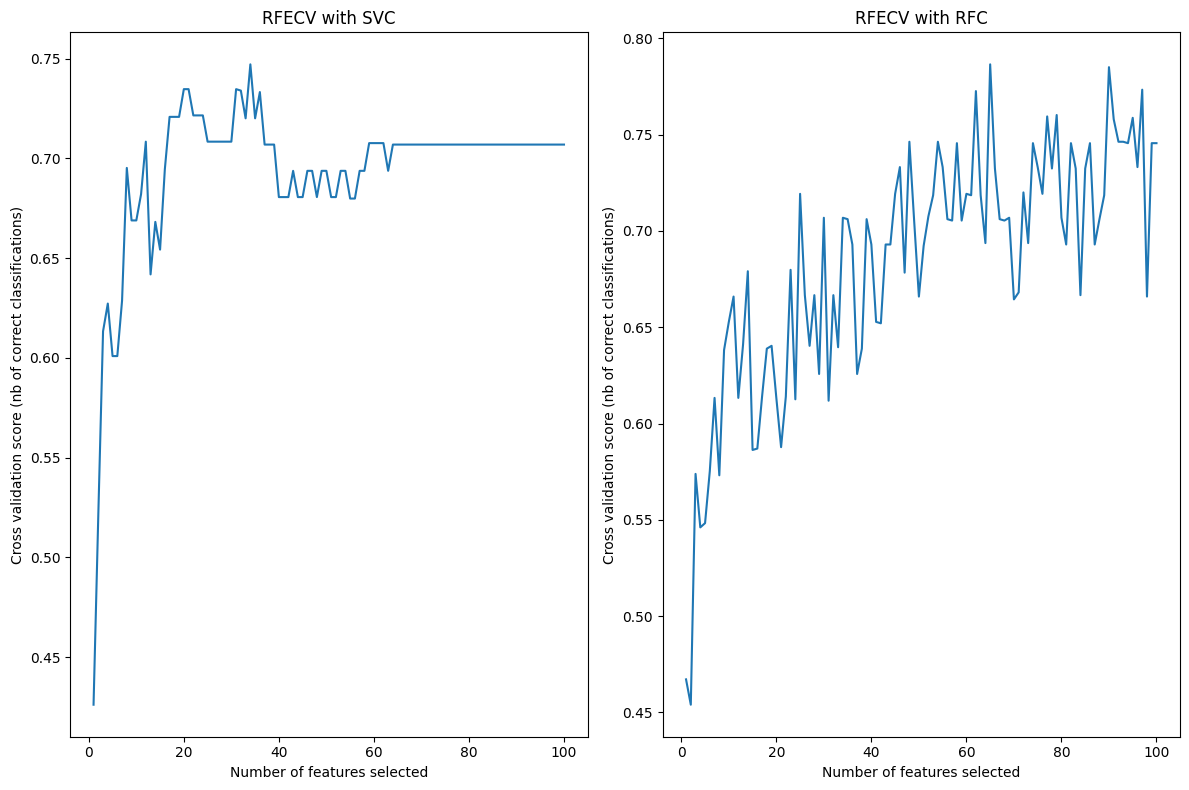

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 8))

#Plot number of features VS. cross-validation scores with SVC
axs[0].plot(range(1, len(rfecv_svc.cv_results_["mean_test_score"]) + 1), rfecv_svc.cv_results_["mean_test_score"])
axs[0].set_title("RFECV with SVC")
axs[0].set_xlabel("Number of features selected")
axs[0].set_ylabel("Cross validation score (nb of correct classifications)")

#Plot number of features VS. cross-validation scores with RFC
axs[1].plot(range(1, len(rfecv_rfc.cv_results_["mean_test_score"]) + 1), rfecv_rfc.cv_results_["mean_test_score"])
axs[1].set_title("RFECV with RFC")
axs[1].set_xlabel("Number of features selected")
axs[1].set_ylabel("Cross validation score (nb of correct classifications)")

plt.tight_layout()
plt.show()

In [ ]:
max_features_selected_svc = X_train_preselected.columns[rfecv_svc.support_]
max_features_selected_rfc = X_train_preselected.columns[rfecv_rfc.support_]

print(f"Maximum cross-validation score for SVC = {len(max_features_selected_svc)} features")
print(f"Maximum cross-validation score for RFC = {len(max_features_selected_rfc)} features")

Maximum cross-validation score for SVC = 34 features
Maximum cross-validation score for RFC = 65 features


In [ ]:
# Creating new dataframes
X_train_selected_svc = X_train_preselected[max_features_selected_svc].copy()
X_train_selected_knn = X_train_preselected.iloc[:, :top_knn]
X_train_selected_rfc = X_train_preselected[max_features_selected_rfc].copy()

print(X_train_selected_svc.shape)
print(X_train_selected_knn.shape)
print(X_train_selected_rfc.shape)

(148, 34)
(148, 20)
(148, 65)


# Model training and Cross validation

Considering the scatterplots, a scalable support vector machine, K-nearest neighbor classiffier and random forest classifier is trained on the traindata. Due to the limited dataset size, both stratified K-fold and Leave-one-out cross validatie are tested. A learning curve and ROC is provided.

SVC model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

cross_validation_method = StratifiedKFold(n_splits=num_folds, shuffle=True)
#cross_validation_method = LeaveOneOut()

model = SVC(probability=True)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(model, param_grid, cv=cross_validation_method, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train_selected_svc, y_train)

best_model_svc = grid_search.best_estimator_

scores_svc = cross_val_score(model, X_train_selected_svc, y_train, cv=cross_validation_method, scoring='accuracy')

print('Cross validated training results for SVC:\n')
print(f'Best model = {best_model_svc}')
print("Mean accuracy over {} folds: {:.2f}%".format(num_folds, scores_svc.mean() * 100))
print("STD of the accuracy: {:.2f}%".format(scores_svc.std() * 100))

Cross validated training results for SVC:

Best model = SVC(C=1, gamma=1, kernel='linear', probability=True)
Mean accuracy over 15 folds: 81.26%
STD of the accuracy: 8.78%


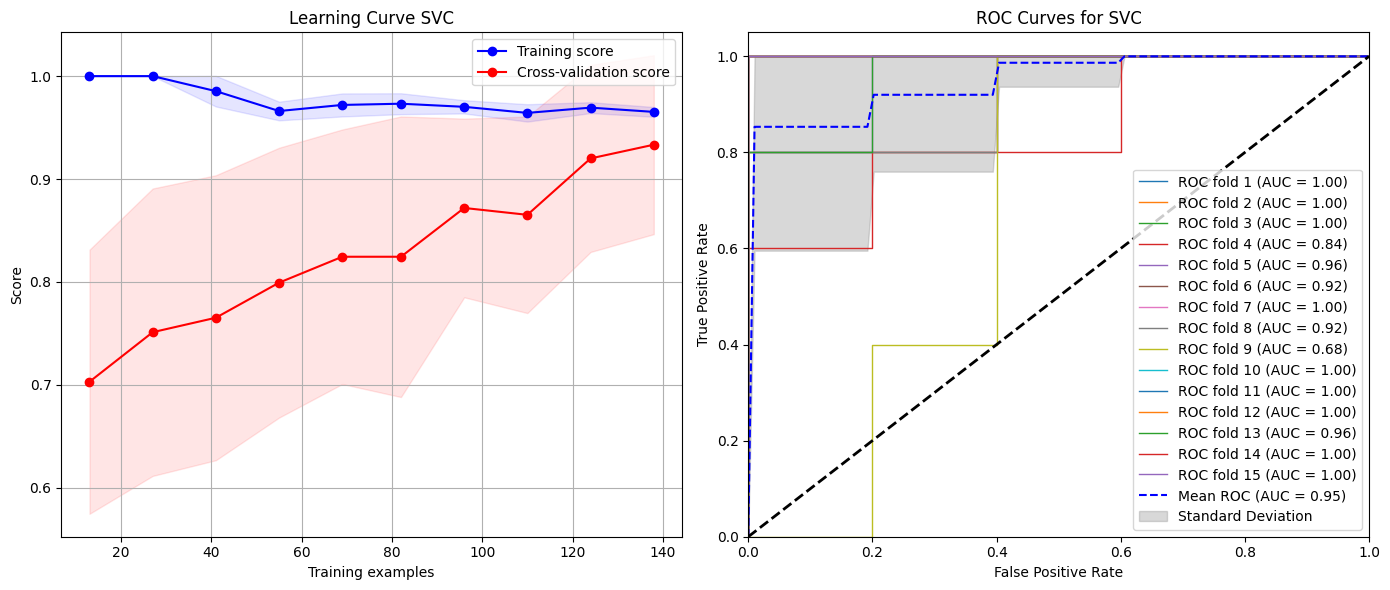

Training sizes:
[ 13  27  41  55  69  82  96 110 124 138]
Training scores mean:
[1.         1.         0.98536585 0.96606061 0.97198068 0.97317073
 0.97013889 0.96424242 0.96935484 0.96521739]
Validation scores mean:
[0.70296296 0.75111111 0.76518519 0.79925926 0.82444444 0.82444444
 0.87185185 0.86518519 0.92       0.93333333]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model_svc,
    X=X_train_selected_svc,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=cross_validation_method,
    scoring='accuracy'
)

# Calculate mean and standard deviation of scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(test_scores, axis=1)
val_scores_std = np.std(test_scores, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot learning curve
axs[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="b")
axs[0].fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="r")
axs[0].plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
axs[0].plot(train_sizes, val_scores_mean, 'o-', color="r", label="Cross-validation score")
axs[0].set_title("Learning Curve SVC")
axs[0].set_xlabel("Training examples")
axs[0].set_ylabel("Score")
axs[0].legend(loc="best")
axs[0].grid(True)

# Predictive value for each cross-validation
y_scores_svc = cross_val_predict(best_model_svc, X_train_selected_svc, y_train, cv=cross_validation_method, method="predict_proba")

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

# Plot ROC-curves for each cross-validation
for i, (train, test) in enumerate(cross_validation_method.split(X_train_selected_svc, y_train)):
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], y_scores_svc[test][:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    axs[1].plot(fpr, tpr, lw=1, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

std_tpr = np.std(tprs, axis=0)
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = mean_tpr - std_tpr

axs[1].fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.3)
axs[1].plot(mean_fpr, mean_tpr, color='b', linestyle='--', label=f'Mean ROC (AUC = {mean_auc:.2f})')
axs[1].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
axs[1].fill_between([], [], [], color='grey', alpha=0.3, label='Standard Deviation')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curves for SVC')
axs[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# additional section
print("Training sizes:")
print(train_sizes)
print("Training scores mean:")
print(train_scores_mean)
print("Validation scores mean:")
print(val_scores_mean)

KNeighbors model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

cross_validation_method = StratifiedKFold(n_splits=num_folds, shuffle=True)
#cross_validation_method = LeaveOneOut()

model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [2, 3, 5, 7, 10, 12, 15, 17, 20, 22, 25],
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(model, param_grid, cv=cross_validation_method, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train_selected_knn, y_train)

best_model_knn = grid_search.best_estimator_

scores_knn = cross_val_score(model, X_train_selected_knn, y_train, cv=cross_validation_method, scoring='accuracy')

print('Cross validated results for KNeighbors Classifier\n')
print(f'Best model = {best_model_knn}')
print("Mean accuracy over {} folds: {:.2f}%".format(num_folds, scores_knn.mean() * 100))
print("STD of the accuracy: {:.2f}%".format(scores_knn.std() * 100))

Cross validated results for KNeighbors Classifier

Best model = KNeighborsClassifier(n_neighbors=22, weights='distance')
Mean accuracy over 15 folds: 66.89%
STD of the accuracy: 11.77%


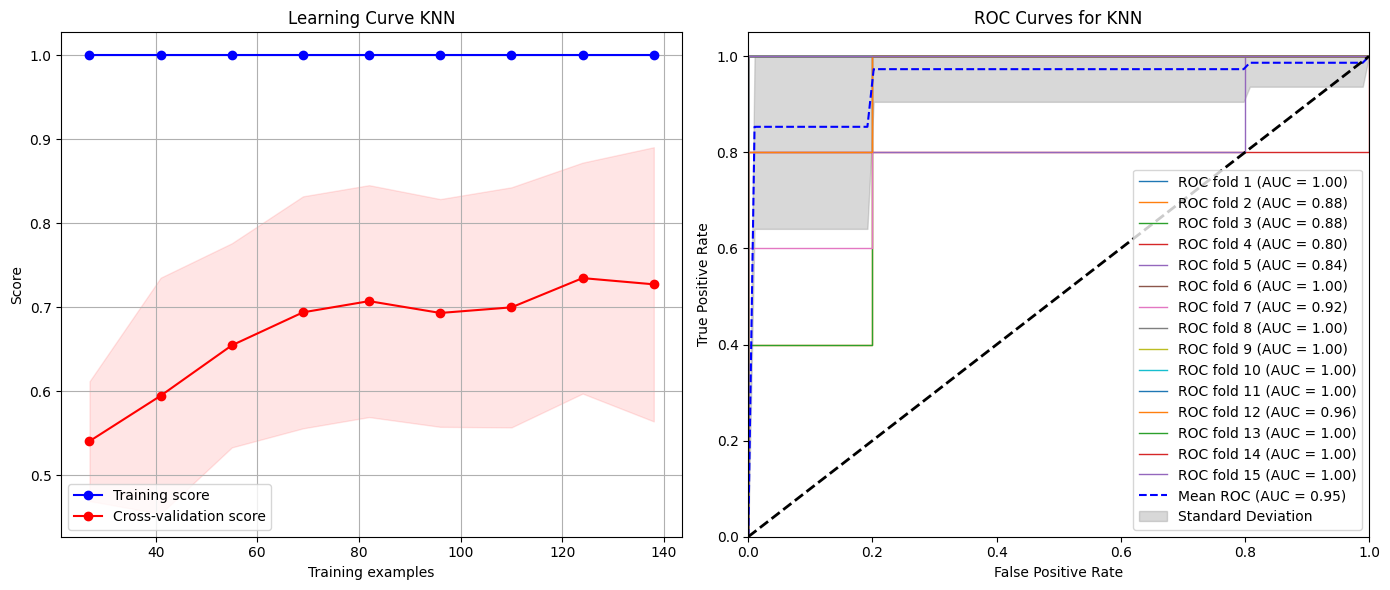

Training sizes:
[ 13  27  41  55  69  82  96 110 124 138]
Training scores mean:
[nan  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Validation scores mean:
[       nan 0.54074074 0.59481481 0.65481481 0.69407407 0.70740741
 0.69333333 0.7        0.73481481 0.72740741]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

# Calculate Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model_knn,
    X=X_train_selected_knn,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=cross_validation_method,
    scoring='accuracy'
)

# Calculate mean and standard deviation of scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(test_scores, axis=1)
val_scores_std = np.std(test_scores, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot learning curve
axs[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="b")
axs[0].fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="r")
axs[0].plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
axs[0].plot(train_sizes, val_scores_mean, 'o-', color="r", label="Cross-validation score")
axs[0].set_title("Learning Curve KNN")
axs[0].set_xlabel("Training examples")
axs[0].set_ylabel("Score")
axs[0].legend(loc="best")
axs[0].grid(True)

# Predictions for each cross-validation
y_scores_knn = cross_val_predict(best_model_knn, X_train_selected_knn, y_train, cv=cross_validation_method, method="predict_proba")

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

# Plot ROC-curves for each cross-validation
for i, (train, test) in enumerate(cross_validation_method.split(X_train_selected_knn, y_train)):
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], y_scores_svc[test][:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    axs[1].plot(fpr, tpr, lw=1, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

std_tpr = np.std(tprs, axis=0)
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = mean_tpr - std_tpr

axs[1].fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.3)
axs[1].plot(mean_fpr, mean_tpr, color='b', linestyle='--', label=f'Mean ROC (AUC = {mean_auc:.2f})')
axs[1].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
axs[1].fill_between([], [], [], color='grey', alpha=0.3, label='Standard Deviation')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curves for KNN')
axs[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Additional section
print("Training sizes:")
print(train_sizes)
print("Training scores mean:")
print(train_scores_mean)
print("Validation scores mean:")
print(val_scores_mean)

# Random Forest classifier

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier

cross_validation_method = StratifiedKFold(n_splits=num_folds, shuffle=True)
#cross_validation_method = LeaveOneOut()

model_rfc = RandomForestClassifier(bootstrap=True)

param_grid_rfc = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': [None, 'sqrt', 'log2', 1]
}

grid_search_rfc = GridSearchCV(model_rfc, param_grid_rfc, cv=cross_validation_method, scoring='accuracy', return_train_score=True)
grid_search_rfc.fit(X_train_selected_rfc, y_train)

best_model_rfc = grid_search_rfc.best_estimator_

scores_rfc = cross_val_score(model, X_train_selected_rfc, y_train, cv=cross_validation_method, scoring='accuracy')

print('Cross validated results for Random Forest Classiefier\n')
print(f'Best model = {best_model_rfc}')
print("Mean accuracy over {} folds: {:.2f}%".format(num_folds, scores_rfc.mean() * 100))
print("STD of the accuracy: {:.2f}%".format(scores_rfc.std() * 100))


Cross validated results for Random Forest Classiefier

Best model = RandomForestClassifier(max_depth=5, max_features=1, min_samples_leaf=2,
                       min_samples_split=10)
Mean accuracy over 15 folds: 68.96%
STD of the accuracy: 15.18%


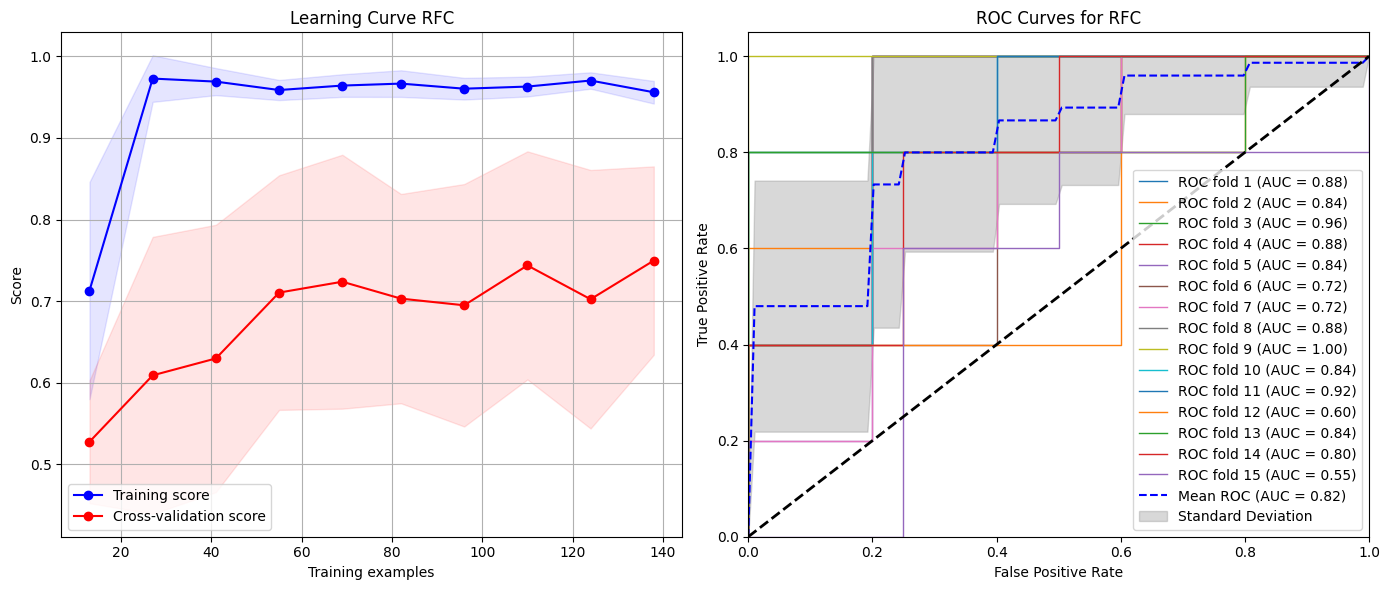

Training sizes:
[ 13  27  41  55  69  82  96 110 124 138]
Training scores mean:
[0.71282051 0.97283951 0.96910569 0.95878788 0.96425121 0.96666667
 0.96041667 0.9630303  0.97043011 0.95603865]
Validation scores mean:
[0.52740741 0.60888889 0.62962963 0.71037037 0.7237037  0.70296296
 0.69481481 0.7437037  0.70222222 0.74962963]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model_rfc,
    X=X_train_selected_rfc,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=cross_validation_method,
    scoring='accuracy'
)

# Calculate mean and standard deviation of scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(test_scores, axis=1)
val_scores_std = np.std(test_scores, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot learning curve
axs[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="b")
axs[0].fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="r")
axs[0].plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
axs[0].plot(train_sizes, val_scores_mean, 'o-', color="r", label="Cross-validation score")
axs[0].set_title("Learning Curve RFC")
axs[0].set_xlabel("Training examples")
axs[0].set_ylabel("Score")
axs[0].legend(loc="best")
axs[0].grid(True)

# Prediction for each cross-validation
y_scores_rfc = cross_val_predict(best_model_rfc, X_train_selected_rfc, y_train, cv=cross_validation_method, method="predict_proba")

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

# Plot ROC-curves for each cross-validation
for i, (train, test) in enumerate(cross_validation_method.split(X_train_selected_rfc, y_train)):
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], y_scores_rfc[test][:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    axs[1].plot(fpr, tpr, lw=1, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

std_tpr = np.std(tprs, axis=0)
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = mean_tpr - std_tpr

axs[1].fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.3)
axs[1].plot(mean_fpr, mean_tpr, color='b', linestyle='--', label=f'Mean ROC (AUC = {mean_auc:.2f})')
axs[1].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
axs[1].fill_between([], [], [], color='grey', alpha=0.3, label='Standard Deviation')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curves for RFC')
axs[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Additional section
print("Training sizes:")
print(train_sizes)
print("Training scores mean:")
print(train_scores_mean)
print("Validation scores mean:")
print(val_scores_mean)

# Test set prepatation

Here, the same operations performed on the train data is performed on the test data (check for duplicates, missing and constant values, scaling and feature selection).

In [ ]:
import pandas as pd

# Check for duplicates
duplicates = X_test[X_test.duplicated()]
if not duplicates.empty:
    print(f"Duplicates found:{duplicates}\n")
else:
    print("No duplicates found\n")

if not duplicates.empty:
    X_test.drop_duplicates(inplace=True)
    print("Duplicates removed\n.")

# check for missing data
missing_values = X_test.columns[X_test.isna().any()].tolist()
if missing_values:
    print(f"colums with missing data: {missing_values}\n")
else:
    print("No missing data found\n")

# Check for constant
constant_columns = X_test.columns[X_test.apply(pd.Series.nunique) == 1].tolist()
print(f"Aantal features with constant values = {len(constant_columns)}")
print(constant_columns)

# Remove features from datalist
X_test.drop(columns=constant_columns, inplace=True)
print(f'New amount of features: {len(X_test.columns)-1}')

No duplicates found

No missing data found

Aantal features with constant values = 21
['PREDICT_original_tf_LBP_min_R3_P12', 'PREDICT_original_tf_LBP_max_R3_P12', 'PREDICT_original_tf_LBP_peak_R3_P12', 'PREDICT_original_tf_LBP_peak_position_R3_P12', 'PREDICT_original_tf_LBP_range_R3_P12', 'PREDICT_original_tf_LBP_min_R8_P24', 'PREDICT_original_tf_LBP_max_R8_P24', 'PREDICT_original_tf_LBP_peak_R8_P24', 'PREDICT_original_tf_LBP_peak_position_R8_P24', 'PREDICT_original_tf_LBP_range_R8_P24', 'PREDICT_original_tf_LBP_max_R15_P36', 'PREDICT_original_tf_LBP_median_R15_P36', 'PREDICT_original_tf_LBP_peak_R15_P36', 'PREDICT_original_tf_LBP_peak_position_R15_P36', 'PREDICT_original_vf_Frangi_inner_peak_position_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_phasef_phasecong_min_WL3_N5', 'PREDICT_original_phasef_phasecong_peak_WL3_N5', 'PREDICT_original_phasef_phasecong_peak_position_WL3_N5', 'PREDICT_original_phasef_phasesym_min_WL3_N5', 'PREDICT_original_phasef_phasesym_peak_WL3_N5', 'PREDICT_original

Testdata scalen

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import pandas as pd

# Initialize the Scaler
#scaler = MinMaxScaler ()
#scaler = StandardScaler()
scaler = RobustScaler()

X_test_copy = X_test
X_test = scaler.fit_transform(X_test)

# Convert created list back to a dataframe:
X_test = pd.DataFrame(X_test, columns=X_test_copy.columns)
print(X_test.shape)

(38, 472)


In [ ]:
#copy of X_test
X_test_1 = X_test
X_test_2 = X_test
X_test_3 = X_test

Test feature selection

In [ ]:
X_test_svc = X_test_1[X_train_selected_svc.columns]
X_test_knn = X_test_2[X_train_selected_knn.columns]
X_test_rfc = X_test_3[X_train_selected_rfc.columns]

print(X_test_svc.shape)
print(X_test_knn.shape)
print(X_test_rfc.shape)

(38, 34)
(38, 20)
(38, 65)


# Evaluation

Run predictions on SVC, KNN and RFC model

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_svc = best_model_svc.predict(X_test_svc)
y_pred_knn = best_model_knn.predict(X_test_knn)
y_pred_rfc = best_model_rfc.predict(X_test_rfc)

Statistics

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

#Precision
precision_svc = precision_score(y_test, y_pred_svc)
precision_knn = precision_score(y_test, y_pred_knn)
precision_rfc = precision_score(y_test, y_pred_rfc)

#Recall
recall_svc = recall_score(y_test, y_pred_svc)
recall_knn = recall_score(y_test, y_pred_knn)
recall_rfc = recall_score(y_test, y_pred_rfc)

#Accuracy
accuracy_svc = accuracy_score(y_test, y_pred_svc)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)

#F1-score
f1_svc = f1_score(y_test, y_pred_svc)
f1_knn = f1_score(y_test, y_pred_knn)
f1_rfc = f1_score(y_test, y_pred_rfc)

# Predict probability
y_pred_prob_svc = best_model_svc.predict_proba(X_test_svc)[:, 1]
y_pred_prob_knn = best_model_knn.predict_proba(X_test_knn)[:, 1]
y_pred_prob_rfc = best_model_rfc.predict_proba(X_test_rfc)[:, 1]

#AUC-ROC
auc_roc_svc = roc_auc_score(y_test, y_pred_prob_svc)
auc_roc_knn = roc_auc_score(y_test, y_pred_prob_knn)
auc_roc_rfc = roc_auc_score(y_test, y_pred_prob_rfc)

#Confusion matrix and specificity
tn_svc, fp_svc, fn_svc, tp_svc = confusion_matrix(y_test, y_pred_svc).ravel()
specificity_svc = tn_svc / (tn_svc + fp_svc)
tn_knn, fp_knn, fn_knn, tp_knn = confusion_matrix(y_test, y_pred_knn).ravel()
specificity_knn = tn_knn / (tn_knn + fp_knn)
tn_rfc, fp_rfc, fn_rfc, tp_rfc = confusion_matrix(y_test, y_pred_rfc).ravel()
specificity_rfc = tn_rfc / (tn_rfc + fp_rfc)

In [ ]:
print("Results testing SVC model:\n")
print(f"precision = {100*precision_svc:.2f}%")
print(f"recall = {100*recall_svc:.2f}%")
print(f"Accuracy = {100*accuracy_svc:.2f} %")
print(f"F1-score = {f1_svc:.2f}")
print(f"AUC-ROC = {auc_roc_svc:.2f}")
print(f"specificity = {100*specificity_svc:.2f} %\n\n")

print("Results testing KNN model:\n")
print(f"precision = {100*precision_knn:.2f}%")
print(f"recall = {100*recall_knn:.2f}%")
print(f"Accuracy = {100*accuracy_knn:.2f} %")
print(f"F1-score = {f1_knn:.2f}")
print(f"AUC-ROC = {auc_roc_knn:.2f}")
print(f"specificity = {100*specificity_knn:.2f} %\n\n")

print("Results testing RFC model:\n")
print(f"precision = {100*precision_rfc:.2f}%")
print(f"recall = {100*recall_rfc:.2f}%")
print(f"Accuracy = {100*accuracy_rfc:.2f} %")
print(f"F1-score = {f1_rfc:.2f}")
print(f"AUC-ROC = {auc_roc_rfc:.2f}")
print(f"specificity = {100*specificity_rfc:.2f} %")

Results testing SVC model:

precision = 73.68%
recall = 73.68%
Accuracy = 73.68 %
F1-score = 0.74
AUC-ROC = 0.83
specificity = 73.68 %


Results testing KNN model:

precision = 68.42%
recall = 68.42%
Accuracy = 68.42 %
F1-score = 0.68
AUC-ROC = 0.75
specificity = 68.42 %


Results testing RFC model:

precision = 68.00%
recall = 89.47%
Accuracy = 73.68 %
F1-score = 0.77
AUC-ROC = 0.76
specificity = 57.89 %


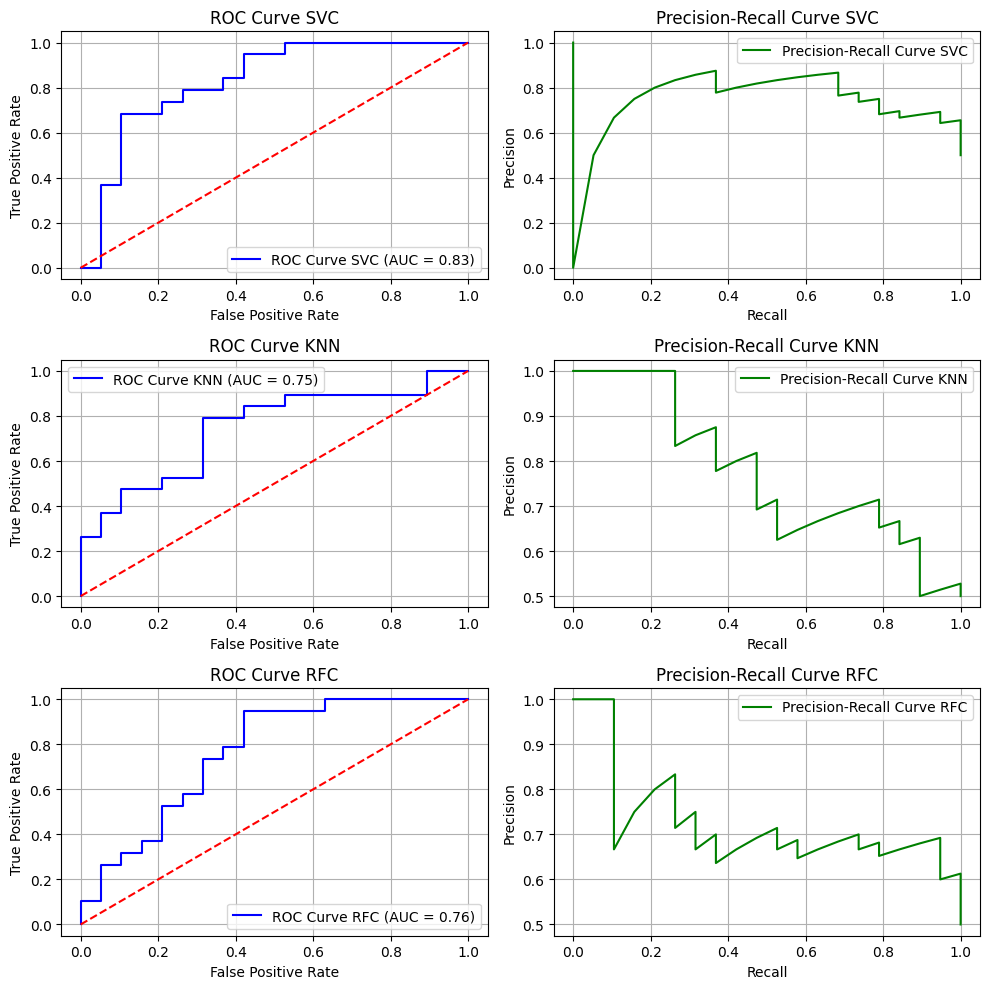

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot

# ROC-curve
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_pred_prob_svc)
auc_roc_svc = auc(fpr_svc, tpr_svc)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_prob_knn)
auc_roc_knn = auc(fpr_knn, tpr_knn)
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_pred_prob_rfc)
auc_roc_rfc = auc(fpr_rfc, tpr_rfc)

#Precision-recall curve
precision_svc, recall_svc, _ = precision_recall_curve(y_test, y_pred_prob_svc)
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_pred_prob_knn)
precision_rfc, recall_rfc, _ = precision_recall_curve(y_test, y_pred_prob_rfc)

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# ROC curve SVC
axs[0, 0].plot(fpr_svc, tpr_svc, color='blue', label='ROC Curve SVC (AUC = {:.2f})'.format(auc_roc_svc))
axs[0, 0].plot([0, 1], [0, 1], color='red', linestyle='--')
axs[0, 0].set_xlabel('False Positive Rate')
axs[0, 0].set_ylabel('True Positive Rate')
axs[0, 0].set_title('ROC Curve SVC')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Precision-recall curve SVC
axs[0, 1].plot(recall_svc, precision_svc, color='green', label='Precision-Recall Curve SVC')
axs[0, 1].set_xlabel('Recall')
axs[0, 1].set_ylabel('Precision')
axs[0, 1].set_title('Precision-Recall Curve SVC')
axs[0, 1].legend()
axs[0, 1].grid(True)

# ROC curve KNN
axs[1, 0].plot(fpr_knn, tpr_knn, color='blue', label='ROC Curve KNN (AUC = {:.2f})'.format(auc_roc_knn))
axs[1, 0].plot([0, 1], [0, 1], color='red', linestyle='--')
axs[1, 0].set_xlabel('False Positive Rate')
axs[1, 0].set_ylabel('True Positive Rate')
axs[1, 0].set_title('ROC Curve KNN')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Precision-recall curve KNN
axs[1, 1].plot(recall_knn, precision_knn, color='green', label='Precision-Recall Curve KNN')
axs[1, 1].set_xlabel('Recall')
axs[1, 1].set_ylabel('Precision')
axs[1, 1].set_title('Precision-Recall Curve KNN')
axs[1, 1].legend()
axs[1, 1].grid(True)

# ROC curve RFC
axs[2, 0].plot(fpr_rfc, tpr_rfc, color='blue', label='ROC Curve RFC (AUC = {:.2f})'.format(auc_roc_rfc))
axs[2, 0].plot([0, 1], [0, 1], color='red', linestyle='--')
axs[2, 0].set_xlabel('False Positive Rate')
axs[2, 0].set_ylabel('True Positive Rate')
axs[2, 0].set_title('ROC Curve RFC')
axs[2, 0].legend()
axs[2, 0].grid(True)

# Precision-recall curve RFC
axs[2, 1].plot(recall_rfc, precision_rfc, color='green', label='Precision-Recall Curve RFC')
axs[2, 1].set_xlabel('Recall')
axs[2, 1].set_ylabel('Precision')
axs[2, 1].set_title('Precision-Recall Curve RFC')
axs[2, 1].legend()
axs[2, 1].grid(True)

plt.tight_layout()
plt.show()